# Training Random Forrest model

Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.
Data can be downloaded from [Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers).

## Data

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils import *
from fastai.imports import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor

#import feather
import IPython
from IPython.display import display
from sklearn import metrics

In [4]:
PATH = "data/Buldozers/"
print("Data to train: ")
!wc -l {PATH}TrainAndValid.csv

Data to train: 
412699 data/Buldozers/TrainAndValid.csv


In [6]:
df_raw = pd.read_csv(f'{PATH}TrainAndValid.csv',low_memory=False, parse_dates=['saledate'])
df_raw.SalePrice = np.log(df_raw.SalePrice)

df_raw.head()

## Preprocessing

In [7]:
# create new features from saledate

add_datepart(df_raw,'saledate')

In [8]:
# create categories

train_cats(df_raw)

df_raw.UsageBand.cat.set_categories(['High','Medium','Low'],ordered=True,inplace=True)

In [10]:
# store data
os.makedirs('tmp',exist_ok=True)
#df_raw.to_feather('tmp/raw')
#feather.write_dataframe(df_raw,'tmp/raw')
df_raw.to_csv('tmp/raw.csv')


In [11]:
# process data

df,y,_= proc_df(df_raw,'SalePrice')

## Fit the RF model 

In [9]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((400698, 66), (400698,), (12000, 66))

In [20]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1,oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 18min, sys: 5.22 s, total: 18min 6s
Wall time: 5min 14s
[0.07539742987194237, 0.24826554259874167, 0.9881795799144557, 0.8870130768942962, 0.9139049078903493]


In [21]:
print_score(m)

[0.07539742987194235, 0.24826554259874167, 0.9881795799144557, 0.8870130768942963, 0.9139049078903493]


## Speading things up

In [11]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)


In [12]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.76 s, sys: 20.1 ms, total: 4.78 s
Wall time: 1.82 s
[0.11478072331250053, 0.4168602765561262, 0.9722559481378564, 0.6814509510731527]


In [13]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)


[0.5254935793426313, 0.595935180688293, 0.4184771272485831, 0.3489814894178266]


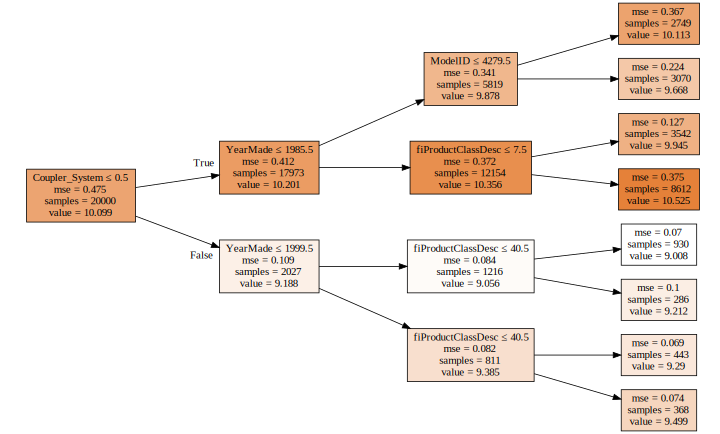

In [15]:
draw_tree(m.estimators_[0], df_trn, precision=3)

## Bagging

In [18]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
#`print_score(m)

preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds.shape

In [19]:
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.852194, 10.518673,  9.769956, 10.518673,  9.769956, 10.491274,  9.769956,  9.769956,  9.852194, 10.341742]),
 10.065457624010183,
 10.768484990022733)

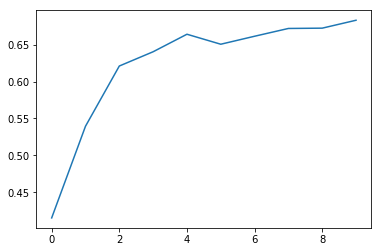

In [20]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

## Reducing overfiting

### 1 Subsampling

In [29]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [31]:
set_rf_samples(20000)

m = RandomForestRegressor(n_jobs=-1,n_estimators=100, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

In [34]:
reset_rf_samples()

### 2 Tree building parameters

In [36]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07803008313790201, 0.25018871870116693, 0.9873397008870987, 0.8852558021997631, 0.909680210948866]


In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11480370684427577, 0.24716418272835636, 0.9725948837129517, 0.8880133223724871, 0.9093507237200875]


In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11882960081447834, 0.23961107662398973, 0.9706391175978176, 0.8947531590179567, 0.9126908323642122]
